In [1]:
import pandas as pd
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np


orign_df = pd.read_csv('../combined_zillow.csv')

In [2]:
orign_df.head(5)

,title,price,bds,ba,sqft,time on zillow,veiws,saves,agent,type,parking,buit,history,HOA,schools,neighborhood_home,zillow_prediction,Zillow,city
0,"428 Silk Tree, Irvine, CA 92606","$565,000",2 bds,2 ba,"1,261 sqft",,,,,,,,,,,,,555733,irvine
1,"47 Spanish Lace, Irvine, CA 92620","$585,000",2 bds,2 ba,"1,279 sqft",77,"3,647",79,Brian Barbour Berkshire Hathaway HomeService,Condo,2 spaces,2006,DATE\tEVENT\tPRICE 12/4/2019\tPrice change\t$5...,$125/mo,8/10 Woodbury Elementary School Grades:K-6 Dis...,Woodbury home values have fallen 0.4 % over th...,Zillow predicts the home values in Woodbury wi...,580856,irvine
2,"213 Carmine, Irvine, CA 92618","$750,000",3 bds,3 ba,"1,619 sqft",90,"10,556",259,Ronnie And Cyrena Berkshire Hathaway HomeService,Single Family,2 spaces,2018,DATE\tEVENT\tPRICE 12/3/2019\tPrice change\t$7...,$216/mo,8/10 Beacon Park Grades:K-8 Distance:0.5 mi NA...,92618 home values have fallen 0.4 % over the p...,Zillow predicts the home values in Orange Coun...,741157,irvine
3,"8 Deodar St, Irvine, CA 92604","$728,800",4 bds,3 ba,"1,642 sqft",82,"13,793",357,Mana Aminian First Team Real Estate,Single Family,2 spaces,1976,DATE\tEVENT\tPRICE 11/13/2019\tPrice change\t$...,$335/mo,8/10 Deerfield Elementary School Grades:K-6 Di...,El Camino Real home values have fallen 0.4 % o...,Zillow predicts the home values in El Camino R...,724958,irvine
4,"137 Silverado, Irvine, CA 92618","$685,000",3 bds,3 ba,"1,756 sqft",165,"5,363",142,Kenneth Chao Coldwell Banker George Realty,Condo,2 spaces,2010,,$134/mo,9/10 Portola Springs Elementary Grades:K-6 Dis...,Portola Springs home values have fallen 0.4 % ...,Zillow predicts the home values in Portola Spr...,671833,irvine


In [3]:
orign_df["zillow_prediction"][1]

'Zillow predicts the home values in Woodbury will fall 0.1% in the next year.'

In [4]:
orign_df["history"][0]

' '

In [5]:
df = orign_df.copy()

In [6]:
df['zipcode'] = df['title'].str[-5:]

In [7]:
# to create neighbor are column
def get_area(row):
    i = row.find("home")
    return row[:i]
df["area"]= df['neighborhood_home'].apply(get_area)

df["area"].value_counts()

92618                256
92602                 77
92612                 74
90301                 49
90302                 46
                    ... 
Bel Air                1
University Hills       1
Harbor Gateway         1
Pico-Robertson         1
Beverlywood            1
Name: area, Length: 125, dtype: int64

In [8]:
df["prediction"] = df["zillow_prediction"].str.split().str[-6]
df["prediction"].value_counts()

increase    637
rise        627
fall        359
decrease    304
Name: prediction, dtype: int64

In [9]:
df["prediction_rate"] = df["zillow_prediction"].str.split().str[-5]
df.drop("zillow_prediction", axis = 1, inplace = True)
df["prediction_rate"].value_counts()


0.8%    260
0%       92
4.5%     92
1.6%     80
0.6%     71
       ... 
3.3%      2
8.2%      2
5.4%      2
9.8%      1
6.3%      1
Name: prediction_rate, Length: 71, dtype: int64

In [10]:
def combine_prediction(row):
    if row == 'rise':
        return "increase"
    elif row == "fall":
        return "decrease"
    else:
        return row

In [11]:
df["prediction_combined"] = df["prediction"].apply(combine_prediction) 
df["prediction_combined"].value_counts()

increase    1264
decrease     663
Name: prediction_combined, dtype: int64

In [12]:
def try_float(x):
    try:
        float(x)
        return True
    except:
        return False

In [13]:
df = df.loc[~df.history.apply(try_float)]

In [14]:
df = df.loc[~df.schools.apply(try_float)]

In [15]:
def school_list(row):
    school_list =[]
    if row == "":
        return None
    else:
        for i, v in enumerate(row.split(':')[::2][:3]):
            ind = v.find('/')
            if i == 0:
                result = [v[:ind], v[ind+3:]]
            else:
                if len(v) > 6:
                    result = [v[ind-1], v[ind+3:]]
                else:
                    result = 'None'
            school_list.append(result)
    return school_list

In [16]:
df["school_list"] = df["schools"].apply(school_list) 
df["school_list"]

0                                                  [[, ]]
1       [[8,  Woodbury Elementary School Grades], [0, ...
2       [[8,  Beacon Park Grades], [e, 5 mi NA Portola...
3       [[8,  Deerfield Elementary School Grades], [8,...
4       [[9,  Portola Springs Elementary Grades], [0, ...
                              ...                        
1954    [[3,  Highland Elementary School Grades], [1, ...
1955    [[2,  Payne (Beulah) Elementary School Grades]...
1956    [[1,  Lane (Warren) Elementary School Grades],...
1957    [[1,  Lane (Warren) Elementary School Grades],...
1958    [[4,  La Tijera School Grades], [1,  Inglewood...
Name: school_list, Length: 1658, dtype: object

In [17]:
def history_convert(row):
    clean_row = row[17:-1].split('\t')
    history_status = [v.strip() for v in clean_row[1::3]]
    history_date = []
    for v in clean_row[::3]:
        if v != '':
            result = datetime.datetime.strptime(v.strip(), '%m/%d/%Y')
            history_date.append(result.date())
        
    history_price = []
    for v in clean_row[2::3]:
        ind = v.find("(")
        if ind > 0:
            result = v[:ind].replace("$", "").replace(",","")
        else:
            result = v.replace("$","").replace(",","")
        history_price.append(float(result))
    
    return (history_date, history_status, history_price)

In [18]:
df["history_date"] = df["history"].apply(lambda row:history_convert(row)[0])
df["history_status"] = df["history"].apply(lambda row:history_convert(row)[1])
df["history_price"]= df["history"].apply(lambda row:history_convert(row)[2])



In [19]:
df["history_date"] 

0                                                      []
1                    [2019-12-04, 2019-10-23, 2006-05-26]
2                                [2019-12-03, 2019-10-10]
3       [2019-11-13, 2019-10-18, 2019-06-06, 2007-08-1...
4                                                      []
                              ...                        
1954                                         [2019-12-04]
1955    [2020-01-08, 2019-12-11, 2019-12-06, 2019-11-2...
1956                 [2006-09-22, 2004-05-14, 2002-12-09]
1957                                         [1999-07-28]
1958    [2009-09-10, 2009-06-13, 2009-04-04, 2008-07-1...
Name: history_date, Length: 1658, dtype: object

In [20]:
df["history_status"]

0                                                      []
1                   [Price change, Listed for sale, Sold]
2                         [Price change, Listed for sale]
3       [Price change, Listed for sale, Sold, Sold, Sold]
4                                                      []
                              ...                        
1954                                    [Listed for sale]
1955    [Back on market, Pending sale, Price change, P...
1956                                   [Sold, Sold, Sold]
1957                                               [Sold]
1958    [Sold, Price change, Listed for sale, Sold, Sold]
Name: history_status, Length: 1658, dtype: object

In [21]:
df["history_price"]

0                                                      []
1                          [585000.0, 600000.0, 518000.0]
2                                    [750000.0, 775000.0]
3       [728800.0, 738800.0, 595500.0, 550000.0, 40500...
4                                                      []
                              ...                        
1954                                           [810000.0]
1955    [509900.0, 509900.0, 509900.0, 514000.0, 50990...
1956                       [580000.0, 399000.0, 170000.0]
1957                                           [175000.0]
1958    [427000.0, 419900.0, 449900.0, 600000.0, 23500...
Name: history_price, Length: 1658, dtype: object

In [22]:
new_df = df.copy()

In [23]:
new_df = new_df.drop(["history","schools","neighborhood_home"], axis = 1)
print(new_df.shape)
new_df.head(5)

(1658, 24)


,title,price,bds,ba,sqft,time on zillow,veiws,saves,agent,type,...,city,zipcode,area,prediction,prediction_rate,prediction_combined,school_list,history_date,history_status,history_price
0,"428 Silk Tree, Irvine, CA 92606","$565,000",2 bds,2 ba,"1,261 sqft",,,,,,...,irvine,92606,,NaN,NaN,NaN,"[[, ]]",[],[],[]
1,"47 Spanish Lace, Irvine, CA 92620","$585,000",2 bds,2 ba,"1,279 sqft",77,"3,647",79,Brian Barbour Berkshire Hathaway HomeService,Condo,...,irvine,92620,Woodbury,fall,0.1%,decrease,"[[8, Woodbury Elementary School Grades], [0, ...","[2019-12-04, 2019-10-23, 2006-05-26]","[Price change, Listed for sale, Sold]","[585000.0, 600000.0, 518000.0]"
2,"213 Carmine, Irvine, CA 92618","$750,000",3 bds,3 ba,"1,619 sqft",90,"10,556",259,Ronnie And Cyrena Berkshire Hathaway HomeService,Single Family,...,irvine,92618,92618,fall,0.8%,decrease,"[[8, Beacon Park Grades], [e, 5 mi NA Portola...","[2019-12-03, 2019-10-10]","[Price change, Listed for sale]","[750000.0, 775000.0]"
3,"8 Deodar St, Irvine, CA 92604","$728,800",4 bds,3 ba,"1,642 sqft",82,"13,793",357,Mana Aminian First Team Real Estate,Single Family,...,irvine,92604,El Camino Real,rise,0.5%,increase,"[[8, Deerfield Elementary School Grades], [8,...","[2019-11-13, 2019-10-18, 2019-06-06, 2007-08-1...","[Price change, Listed for sale, Sold, Sold, Sold]","[728800.0, 738800.0, 595500.0, 550000.0, 40500..."
4,"137 Silverado, Irvine, CA 92618","$685,000",3 bds,3 ba,"1,756 sqft",165,"5,363",142,Kenneth Chao Coldwell Banker George Realty,Condo,...,irvine,92618,Portola Springs,decrease,0.6%,decrease,"[[9, Portola Springs Elementary Grades], [0, ...",[],[],[]


In [24]:
# after excluding the studio, and lot records and then convert the rest of records from string to float data type 
new_df = new_df[(new_df["bds"] != "Studio") & (new_df["bds"].str.split().str[-1] != 'lot')]
new_df["bds"] = new_df["bds"].str.split().str[0].astype('int')
print(new_df.shape)
new_df["bds"].unique()


(1605, 24)


array([ 2,  3,  4,  7,  5,  6,  1,  8, 10, 17, 14, 12,  9, 15, 13, 11, 40])

In [25]:
# same as the baths
new_df = new_df[new_df["ba"] !='#NAME?']
new_df["ba"] = new_df["ba"].str.split().str[0].astype('float')
print(new_df.shape)
new_df["ba"].unique()



(1601, 24)


array([ 2. ,  3. , 11. ,  5. ,  4. ,  2.5,  9. ,  1. ,  6. ,  8. , 13. ,
        7. , 10. ,  1.5,  3.5,  4.5,  5.5,  nan, 40. ])

In [26]:
new_df["sqft"].value_counts(ascending = True)

1,720 sqft      1
2,193 sqft      1
1,505 sqft      1
3,491 sqft      1
3,670 sqft      1
             ... 
1 bd           20
5 bds          22
4 bds          44
2 bds          91
3 bds         101
Name: sqft, Length: 978, dtype: int64

In [27]:
# finding weird data of sqft column
def convert_sqft(row):
    result = row.split(" ")
    if result[-1] == 'sqft':
        return float(result[0].replace(",",""))
    else:
        return 0


In [28]:
new_df["sqft_num"] = new_df["sqft"].apply(convert_sqft)
new_df["sqft_num"].value_counts()

0.0       305
1204.0      8
1300.0      6
1800.0      5
1440.0      5
         ... 
3703.0      1
1947.0      1
1418.0      1
4906.0      1
1756.0      1
Name: sqft_num, Length: 964, dtype: int64

In [29]:
new_df["time on zillow"] = new_df["time on zillow"].str[:-4]

In [30]:
new_df["prediction_rate"] = new_df["prediction_rate"].str.replace("%","").astype('float')

In [31]:
new_df["prediction_rate"].value_counts()

0.8    90
4.5    87
1.4    59
0.6    59
2.1    57
       ..
6.0     2
5.4     2
8.2     2
9.8     1
6.3     1
Name: prediction_rate, Length: 71, dtype: int64

In [32]:
import numpy as np
new_df["time on zillow"] = pd.to_numeric(new_df["time on zillow"], errors='coerce').fillna(0).astype(np.int64)
new_df["veiws"] = pd.to_numeric(new_df["veiws"], errors='coerce').fillna(0).astype(np.int64)
new_df["saves"] = pd.to_numeric(new_df["saves"], errors='coerce').fillna(0).astype(np.int64)
new_df["Zillow"] = pd.to_numeric(new_df["Zillow"], errors='coerce').fillna(0).astype(np.int64)

In [33]:
new_df.head(5)

,title,price,bds,ba,sqft,time on zillow,veiws,saves,agent,type,...,zipcode,area,prediction,prediction_rate,prediction_combined,school_list,history_date,history_status,history_price,sqft_num
0,"428 Silk Tree, Irvine, CA 92606","$565,000",2,2.0,"1,261 sqft",0,0,0,,,...,92606,,NaN,NaN,NaN,"[[, ]]",[],[],[],1261.0
1,"47 Spanish Lace, Irvine, CA 92620","$585,000",2,2.0,"1,279 sqft",0,0,79,Brian Barbour Berkshire Hathaway HomeService,Condo,...,92620,Woodbury,fall,0.1,decrease,"[[8, Woodbury Elementary School Grades], [0, ...","[2019-12-04, 2019-10-23, 2006-05-26]","[Price change, Listed for sale, Sold]","[585000.0, 600000.0, 518000.0]",1279.0
2,"213 Carmine, Irvine, CA 92618","$750,000",3,3.0,"1,619 sqft",0,0,259,Ronnie And Cyrena Berkshire Hathaway HomeService,Single Family,...,92618,92618,fall,0.8,decrease,"[[8, Beacon Park Grades], [e, 5 mi NA Portola...","[2019-12-03, 2019-10-10]","[Price change, Listed for sale]","[750000.0, 775000.0]",1619.0
3,"8 Deodar St, Irvine, CA 92604","$728,800",4,3.0,"1,642 sqft",0,0,357,Mana Aminian First Team Real Estate,Single Family,...,92604,El Camino Real,rise,0.5,increase,"[[8, Deerfield Elementary School Grades], [8,...","[2019-11-13, 2019-10-18, 2019-06-06, 2007-08-1...","[Price change, Listed for sale, Sold, Sold, Sold]","[728800.0, 738800.0, 595500.0, 550000.0, 40500...",1642.0
4,"137 Silverado, Irvine, CA 92618","$685,000",3,3.0,"1,756 sqft",0,0,142,Kenneth Chao Coldwell Banker George Realty,Condo,...,92618,Portola Springs,decrease,0.6,decrease,"[[9, Portola Springs Elementary Grades], [0, ...",[],[],[],1756.0


In [34]:
new_df["first_school_grade"] = new_df["school_list"].str[0].str[0]
new_df["first_school_grade"] = pd.to_numeric(new_df["first_school_grade"], errors='coerce').fillna(0).astype(np.int64)
new_df["first_school"] = new_df["school_list"].str[0].str[1]
new_df["second_school_grade"] = new_df["school_list"].str[1].str[0]
new_df["second_school"] = new_df["school_list"].str[1].str[1]
new_df["third_school_grade"] = new_df["school_list"].str[2].str[0]
new_df["third_school"] = new_df["school_list"].str[2].str[1]

In [35]:
new_df[["first_school_grade","first_school","second_school_grade","second_school","third_school_grade","third_school"]]

,first_school_grade,first_school,second_school_grade,second_school,third_school_grade,third_school
0,0,,NaN,NaN,NaN,NaN
1,8,Woodbury Elementary School Grades,0,Jeffrey Trail Middle Grades,e,5 mi NA Portola High Grades
2,8,Beacon Park Grades,e,5 mi NA Portola High Grades,N,o
3,8,Deerfield Elementary School Grades,8,Venado Middle School Grades,9,Irvine High School Grades
4,9,Portola Springs Elementary Grades,0,Jeffrey Trail Middle Grades,e,8 mi NA Portola High Grades
...,...,...,...,...,...,...
1954,3,Highland Elementary School Grades,1,Crozier (George W.) Middle School Grades,1,Inglewood High School Grades
1955,2,Payne (Beulah) Elementary School Grades,1,Crozier (George W.) Middle School Grades,3,Morningside High School Grades
1956,1,Lane (Warren) Elementary School Grades,2,Monroe (Albert F.) Middle School Grades,1,Inglewood High School Grades
1957,1,Lane (Warren) Elementary School Grades,2,Monroe (Albert F.) Middle School Grades,1,Morningside High School Grades


In [36]:
new_df.describe()

,bds,ba,time on zillow,veiws,saves,Zillow,prediction_rate,sqft_num,first_school_grade
count,1601.000000,1463.000000,1601.000000,1601.000000,1601.000000,1.601000e+03,1570.000000,1601.000000,1601.000000
mean,3.251093,2.916951,0.002498,184.731418,50.459713,1.081722e+06,3.092229,1713.208620,5.938788
std,1.789738,1.738488,0.049937,289.831326,64.684666,1.316220e+06,2.687014,1731.732748,2.783658
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,11.000000,5.540360e+05,0.800000,860.000000,3.000000
50%,3.000000,3.000000,0.000000,0.000000,30.000000,7.816680e+05,2.200000,1450.000000,7.000000
75%,4.000000,3.000000,0.000000,328.000000,67.000000,1.132962e+06,4.700000,2137.000000,8.000000
max,40.000000,40.000000,1.000000,997.000000,730.000000,1.770889e+07,12.500000,17400.000000,10.000000


In [37]:
corr_df = new_df[["bds","ba","sqft_num","first_school_grade","Zillow"]]

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


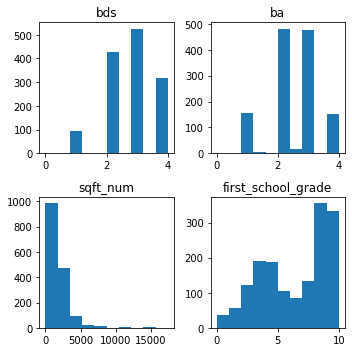

In [38]:
fig, axs = plt.subplots(2,2, figsize = (5,5))

c_columns= ["bds","ba","sqft_num","first_school_grade"]
for i, ax in enumerate(axs.flatten()):
    if i <= 1:
        ax.hist(new_df[c_columns[i]], range=(0,4))
    else:
        ax.hist(new_df[c_columns[i]])
    ax.set_title('{}'.format(c_columns[i]))

plt.tight_layout()
plt.savefig("Distribution of Data.png")    
plt.show()

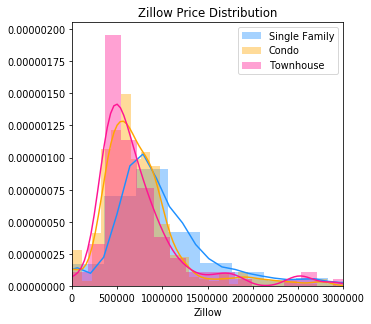

In [39]:
#sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
#sns.set_context("paper", font_scale=0.9) 

x1 = new_df.loc[new_df['type'] == 'Single Family', ['Zillow']]
x2 = new_df.loc[new_df['type'] == 'Condo', ['Zillow']]
x3 = new_df.loc[new_df['type'] == 'Townhouse', ['Zillow']]
plt.subplots(figsize=(5,5), dpi=70)
sns.distplot(new_df.loc[new_df.type=='Single Family', "Zillow"] , color="dodgerblue", label="Single Family")
sns.distplot(new_df.loc[new_df.type=='Condo', "Zillow"] , color="orange", label="Condo")
sns.distplot(new_df.loc[new_df.type=='Townhouse', "Zillow"] , color="deeppink", label="Townhouse")

plt.title('Zillow Price Distribution')
plt.xlim([0,3000000])
plt.savefig("Zillow Price Distribution by House Type.png")
plt.legend();

In [40]:
corr = corr_df.corr()
corr
# plot the heatmap
#sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

,bds,ba,sqft_num,first_school_grade,Zillow
bds,1.000000,0.842192,0.415123,0.125151,0.390470
ba,0.842192,1.000000,0.478065,0.204089,0.562041
sqft_num,0.415123,0.478065,1.000000,0.272773,0.621000
first_school_grade,0.125151,0.204089,0.272773,1.000000,0.260811
Zillow,0.390470,0.562041,0.621000,0.260811,1.000000


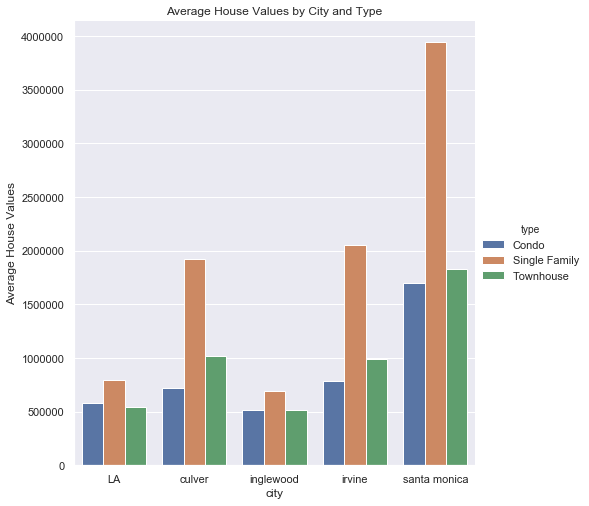

In [41]:
interest_type = ['Condo','Single Family','Townhouse']
new_df = new_df[new_df['Zillow'] != 0]
city_type_g = new_df.loc[new_df['type'].isin(interest_type)].groupby(['city','type']).Zillow.agg(['count','min','max','mean'])
city_type_g_df = city_type_g.reset_index()

sns.set(font_scale = 1)
sns.catplot(x='city',y= 'mean', hue ='type', kind='bar', data=city_type_g_df, height = 7)
plt.rcParams["axes.labelsize"] = 4
plt.ylabel('Average House Values')
plt.title('Average House Values by City and Type')
plt.savefig("Average House Values by City and Type.png")
plt.show()


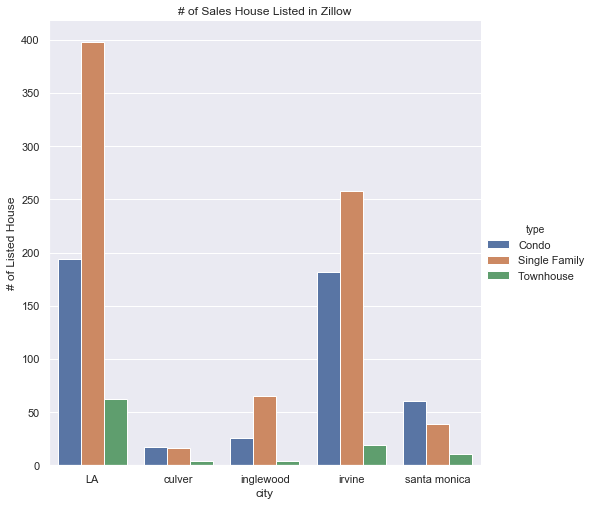

In [42]:
sns.set(font_scale = 1)
sns.catplot(x='city',y= 'count', hue ='type', kind='bar', data=city_type_g_df, height = 7)
plt.rcParams["axes.labelsize"] = 4
plt.ylabel('# of Listed House')
plt.title('# of Sales House Listed in Zillow')
plt.savefig('Sales House Listed in Zillow.png')
plt.show()

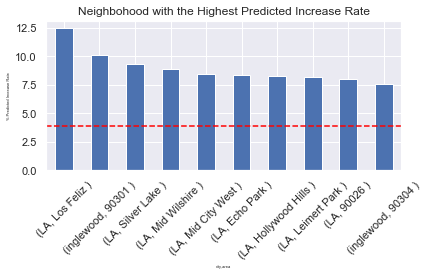

In [43]:
# second one  neighbohood with the highest predicted increase

new_df[new_df['prediction'] =='increase'].groupby(['city','area']).prediction_rate.max().sort_values(ascending = False)[:10].plot.bar(rot=45)

increase_df = new_df[new_df["prediction_combined"] == "increase"]
avg_increase = increase_df["prediction_rate"].mean()
plt.axhline(avg_increase, color="red", linestyle="--", label='Average Increase Rate')
plt.title('Neighbohood with the Highest Predicted Increase Rate')
plt.ylabel('% Predicted Increase Rate')
plt.tight_layout()
plt.savefig("Neighbohood with the Highest Predicted Increase.png")


In [44]:

prediction_corr = increase_df[['prediction_rate', "saves","veiws","bds","sqft","ba"]]
prediction_corr.corr()

,prediction_rate,saves,veiws,bds,ba
prediction_rate,1.000000,0.052005,-0.016233,-0.108184,-0.159198
saves,0.052005,1.000000,-0.331588,-0.069002,-0.058852
veiws,-0.016233,-0.331588,1.000000,0.065326,0.029321
bds,-0.108184,-0.069002,0.065326,1.000000,0.865697
ba,-0.159198,-0.058852,0.029321,0.865697,1.000000


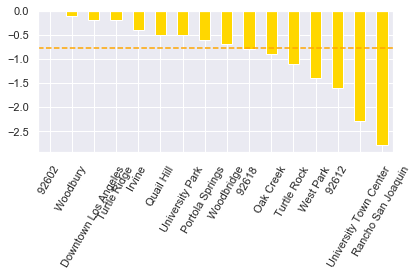

In [45]:
fig, ax = plt.subplots()
decrease_city_area_g = new_df[new_df['prediction'] =='decrease'].groupby(['city','area']).prediction_rate.max().sort_values()
decrease_city_area_g_df = decrease_city_area_g.reset_index()
decrease_city_area_g_df["negative_rate"] = decrease_city_area_g_df["prediction_rate"] * -1
decrease_city_area_g_df["negative_rate"].plot.bar(color='gold')

decrease_df = new_df[new_df["prediction_combined"] == "decrease"]
avg_decrease = (decrease_df["prediction_rate"].mean())*-1
ax.axhline(avg_decrease, color="orange", linestyle="--", label='Average Decrease Rate')
xlabel = [v[1] for v in decrease_city_area_g.index]
ax.set_xticklabels(xlabel, rotation=60)
plt.savefig("Neighbohood with the Highest Predicted Decrease.png")
plt.tight_layout()
plt.show()

In [46]:
new_df[(new_df["second_school_grade"] =="e") | (new_df["second_school_grade"] =="N")].city.value_counts()

irvine    62
LA         1
Name: city, dtype: int64

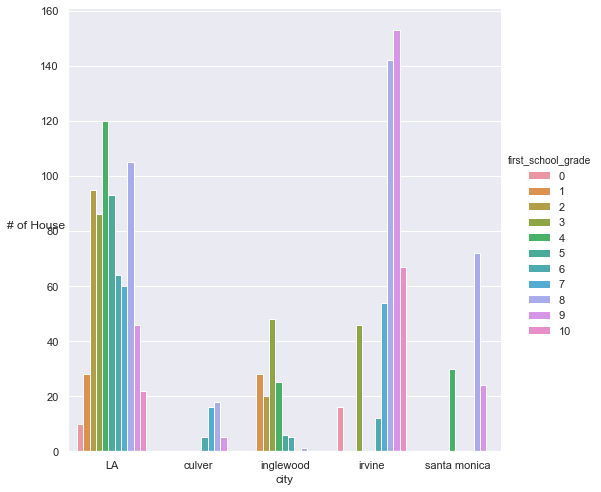

In [47]:
first_school_g = new_df.groupby(["city","first_school_grade"]).title.count()
first_school_g_df = first_school_g.reset_index()
first_school_g_df

sns.set(font_scale = 1)
sns.catplot(x='city',y= 'title', hue ='first_school_grade', kind='bar', data=first_school_g_df, height = 7)
plt.rcParams["axes.labelsize"] = 4
plt.ylabel("# of House", rotation=0)
plt.savefig("Distribution of Number of House by First School Grade.png")
plt.show()

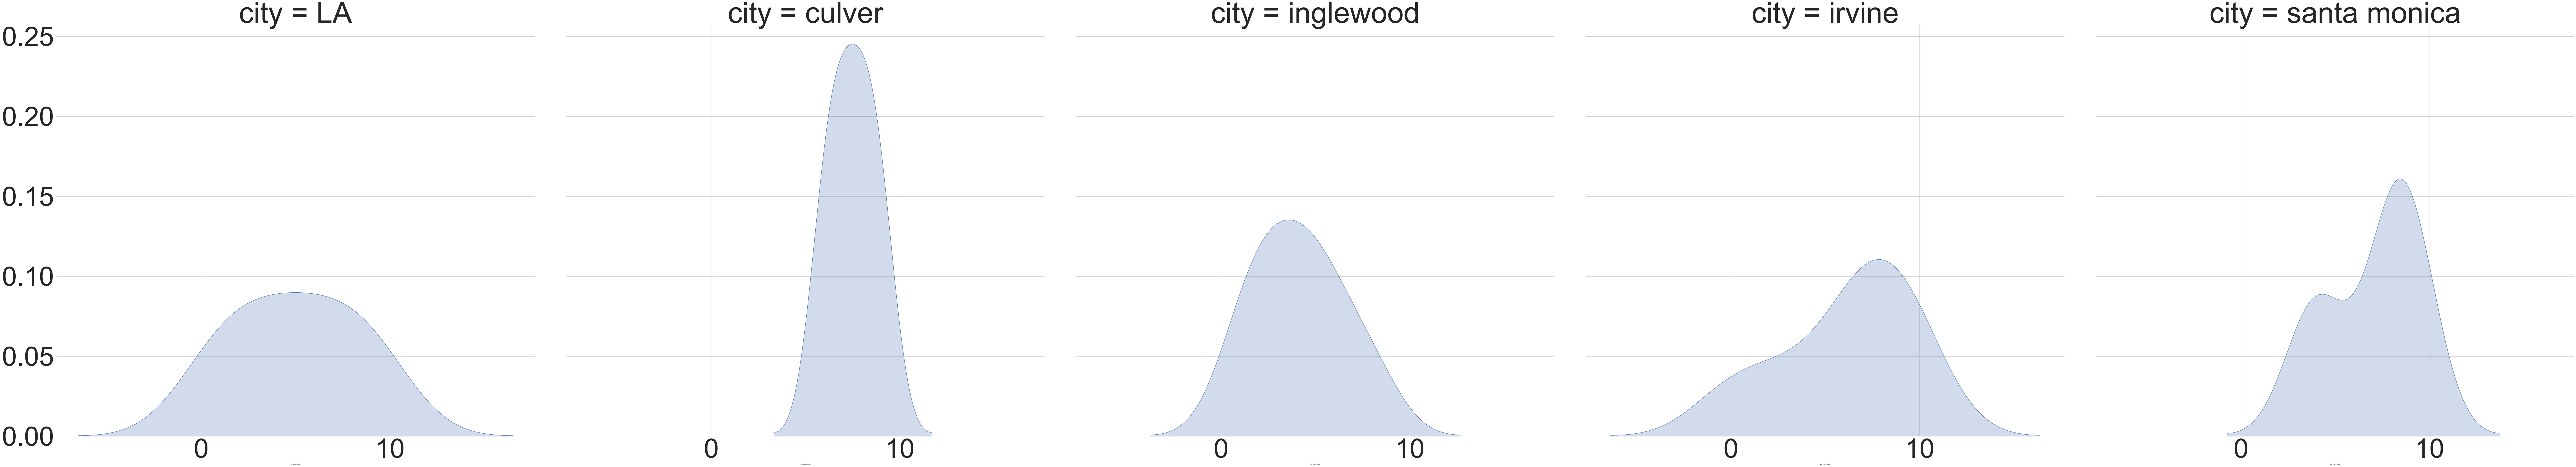

In [67]:
g= sns.FacetGrid(first_school_g_df, col = 'city', height =30)
sns.set(font_scale = 10)
g.map(sns.kdeplot, "first_school_grade", shade = True)
sns.despine(left = True, bottom = True)
sns.set_style("whitegrid")
plt.rcParams["axes.labelsize"] = 5
plt.show()

In [49]:
first_school_zillow_g = new_df.groupby(["city","first_school_grade"]).agg({'title':'count', 'Zillow':'mean'}) 
first_school_zillow_g_df = first_school_zillow_g.reset_index()
first_school_zillow_g_df

,city,first_school_grade,title,Zillow
0,LA,0,10,7.212075e+05
1,LA,1,28,6.298347e+05
2,LA,2,95,6.199739e+05
3,LA,3,86,6.495892e+05
4,LA,4,120,6.014643e+05
5,LA,5,93,7.042539e+05
6,LA,6,64,6.423013e+05
7,LA,7,60,6.860493e+05
8,LA,8,105,7.905362e+05
9,LA,9,46,8.263811e+05


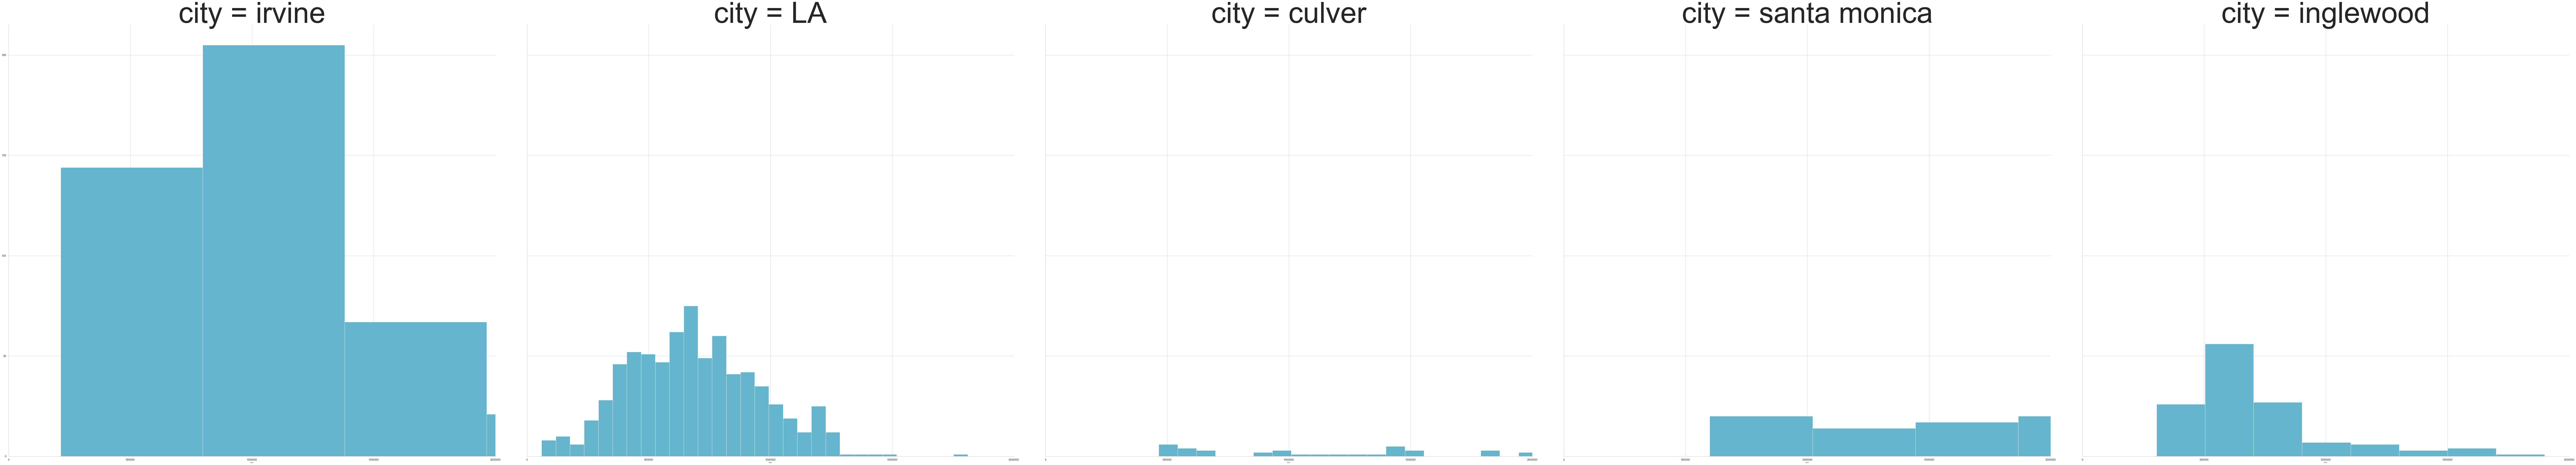

In [66]:
g= sns.FacetGrid(new_df, col = 'city', height =30)
sns.set(font_scale = 10)
g.map(plt.hist, "Zillow", color="c", bins=30)
sns.set_style("whitegrid")
plt.rcParams["axes.labelsize"] = 5
plt.xlim([0,2000000])
plt.savefig("House Values Distribution by City.png")
plt.show()

Null Hypothesis Test

In [51]:
new_df.groupby("city").title.count()

city
LA              729
culver           44
inglewood       133
irvine          490
santa monica    126
Name: title, dtype: int64

In [52]:
new_df.groupby(["city","type"]).title.count()

city          type                 
LA                                       4
              Condo                    194
              Cooperative                5
              Mobile / Manufactured     27
              Multi Family              39
              Single Family            398
              Townhouse                 62
culver        Condo                     17
              Multi Family               6
              Multiple Occupancy         1
              Single Family             16
              Townhouse                  4
inglewood     Condo                     26
              Multi Family              30
              Multiple Occupancy         8
              Single Family             65
              Townhouse                  4
irvine                                  17
              Condo                    182
              Miscellaneous              1
              Mobile / Manufactured     12
              Multi Family               1
              Sing

In [53]:
two_city = ["LA","irvine"]
la_irvine = new_df.loc[new_df['city'].isin(two_city)]
la_irvine_single = la_irvine[la_irvine["type"] == 'Single Family']
la_irvine_single.shape

(656, 31)

In [54]:
la_irvine_single_school = la_irvine_single[la_irvine_single["first_school_grade"] >=7]
la_irvine_single_school.shape

(375, 31)

In [55]:
la_irvine_single_school["city"].value_counts()

irvine    246
LA        129
Name: city, dtype: int64

Null Hypothesis = LA's average house values are greater than Irvine's if comparing the values near great schools district.

In [56]:
la_irvine_single_school[la_irvine_single_school["city"] =='LA']["Zillow"].value_counts(ascending = True)

914432     1
651704     1
1118902    1
1235381    1
749002     1
          ..
650060     1
1250120    1
1810247    1
885637     1
1019391    1
Name: Zillow, Length: 129, dtype: int64

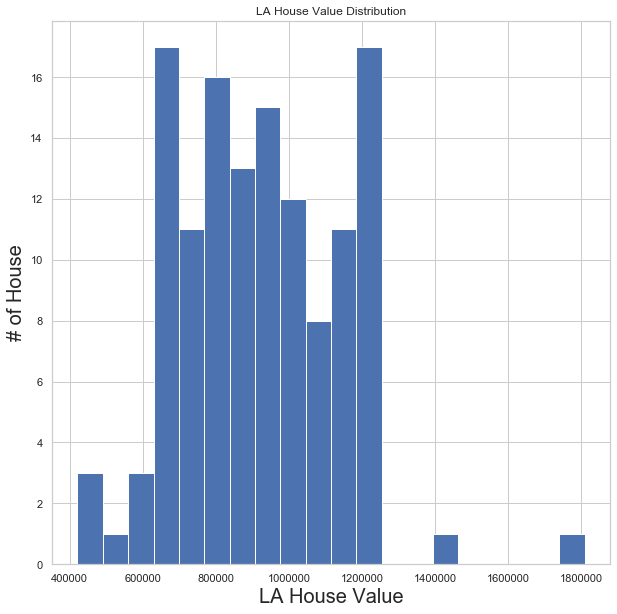

In [57]:
import matplotlib
fig, ax= plt.subplots(figsize=(10,10))
la = la_irvine_single_school[la_irvine_single_school["city"] =='LA']["Zillow"]
irvine = la_irvine_single_school[la_irvine_single_school["city"] =='irvine']["Zillow"]

ax.hist(la, bins = 20)
plt.xlabel ('LA House Value', fontsize = 20)
plt.ylabel ('# of House',fontsize = 20)
plt.title ('LA House Value Distribution')
plt.savefig("LA House Value Distribution.png")

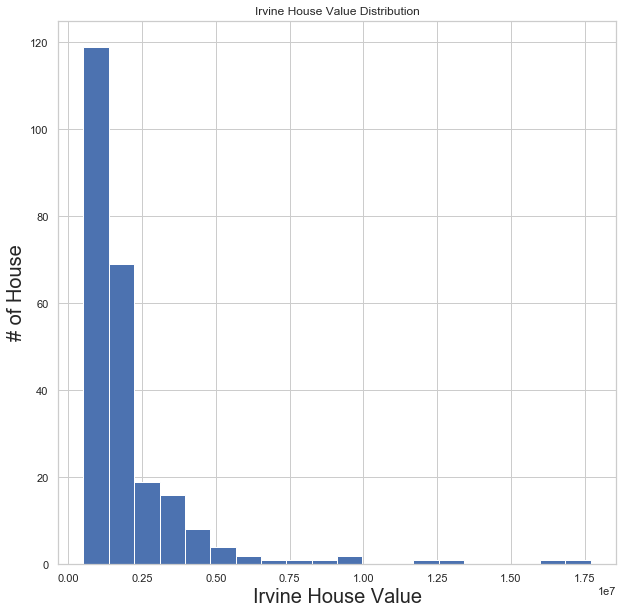

In [58]:
fig, ax= plt.subplots(figsize=(10,10))
ax.hist(irvine, bins = 20)
plt.xlabel ('Irvine House Value', fontsize = 20)
plt.ylabel ('# of House',fontsize = 20)
plt.title ('Irvine House Value Distribution')
plt.savefig("Irvine House Value Distribution.png")

In [59]:
la_u = la.mean()
irvine_u = irvine.mean()
la_std = np.std(la)
irvine_std = np.std(irvine)
la_u, la_std, irvine_u, irvine_std

(920372.3488372093, 223806.38107236297, 2101581.1666666665, 2202715.8497275645)

In [60]:
la.describe()

count    1.290000e+02
mean     9.203723e+05
std      2.246789e+05
min      4.211120e+05
25%      7.554530e+05
50%      9.078470e+05
75%      1.097645e+06
max      1.810247e+06
Name: Zillow, dtype: float64

In [61]:
irvine.describe()

count    2.460000e+02
mean     2.101581e+06
std      2.207207e+06
min      5.134930e+05
25%      1.062628e+06
50%      1.405984e+06
75%      2.099562e+06
max      1.770889e+07
Name: Zillow, dtype: float64

In [62]:
def count_winning_pairs(sample_1, sample_2):
    sample_1, sample_2 = np.array(sample_1), np.array(sample_2)
    n_total_wins = 0
    for x in sample_1:
        n_wins = np.sum(x > sample_2) + 0.5*np.sum(x == sample_2)
        n_total_wins += n_wins
    return n_total_wins

In [63]:
count_winning_pairs(la, irvine)

4979.0

In [64]:
la_wins = count_winning_pairs(la, irvine)
irvine_wins = count_winning_pairs(irvine, la)
print("Number of la Wins: {}".format(la_wins))
print("Number of irvine Wins: {}".format(irvine_wins))


Number of la Wins: 4979.0
Number of irvine Wins: 26755.0


In [65]:
from scipy import stats 

In [101]:
res = stats.mannwhitneyu(irvine, la, alternative="greater")
print("p-value for irvine < la:", res.pvalue)

p-value for irvine < la: 4.702408972142607e-28
